In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

def resize_img(img, height=None, width=None, ratio=None):
    h, w = img.shape
    dim = None
    if ratio:
        dim = (w / ratio, h / ratio)
    elif width and height:
        dim = (width, height)
    elif height:
        r = height / float(h)
        dim = (int(w * r), height)
    elif width:
        r = width / float(w)
        dim = (width, int(h * r))
    assert dim, AssertionError("dim is None")
    return cv2.resize(img, dim, cv2.INTER_CUBIC)

In [3]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
dataset = datasets.MNIST(root='data', train=True, download=False, transform=ToTensor())

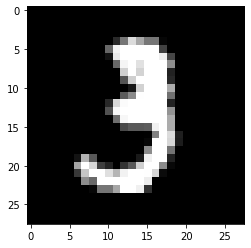

In [5]:
imshow(dataset.data[10])

In [6]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [7]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data', train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.sigmoid(self.fc(x))
        return F.log_softmax(x)

In [10]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [11]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292201
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.817558
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.737388
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.730071
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.729892
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.740071
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.669701
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.674009
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.653494
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.632052


/Users/timur/.pyenv/versions/3.7.10/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.6461, Accuracy: 8776/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.643717
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.606779
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.669997
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.641286
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.649328
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.613128
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.634467
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.605884
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.655666
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.645501

Test set: Avg. loss: 1.6164, Accuracy: 8882/10000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.629586
Train Epoch: 3 [6400/60000 (11%)]	Loss: 1.560909
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.639778
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.598402
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.581700
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.599561
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.607303
Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.612

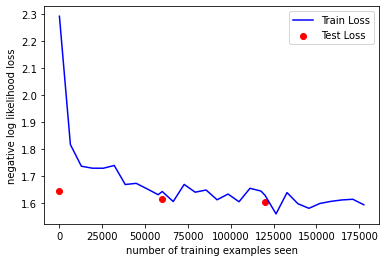

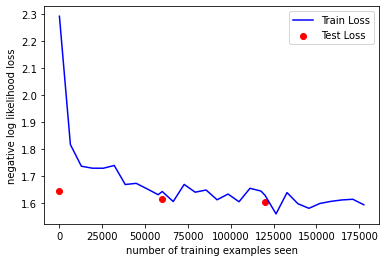

In [17]:
fig = plt.figure()
plt.plot(train_counter[:len(train_losses)], train_losses, color='blue')
plt.scatter(test_counter[:len(test_losses)], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
# Class Neural Network, defines multiple layers and runs forwad and back propogation to train the network.
class NeuralNetwork:
    
    # defines the shape of Network and initializes layers
    def __init__(self, shape):
        self.shape = shape
        self.layers = list()
        self.log_loss_hist = list()
        j = 0
        for i in shape:
            self.layers.append(Layer(i,j))
            j = j + 1
        
    # Initializes the weights and biases of our network for each layer
    def initialize(self, X, y):
        for i in range(len(self.layers)):
            if i == 0:
                self.layers[i].init_weight(X.shape[1], self.layers[i].size)
            else:
                self.layers[i].init_weight(self.layers[i-1].size, self.layers[i].size)
       
    # performs forward propogation
    def forward_propogation(self, X):
        a = X.T
        for layer in self.layers:
            a =
            a = layer.activation(a)
            print(a.shape)
            
    # calculates log logs and return the result
    def loss(self, outputs, y):
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        outputs_lb = lb.transform(outputs)
        loss = log_loss(y_lb, outputs_lb)
        return loss
    
    # Performs the most critical, Backpropogation to calculate delta values for each layer
    def backpropogate(self, X, y):
        delta = list()
        delta_w = [0 for _ in range(len(self.layers))]
        delta_b = [0 for _ in range(len(self.layers))]
        error_o = (self.layers[-1].z - y.T)
        for i in reversed(range(len(self.layers) - 1)):
            error_i = np.multiply(self.layers[i+1].weights.T.dot(error_o), self.layers[i].activation_grad())
            delta_w[i+1] = error_o.dot(self.layers[i].a.T)/len(y)
            delta_b[i+1] = np.sum(error_o, axis=1, keepdims=True)/len(y)
            error_o = error_i
        delta_w[0] = error_o.dot(X)
        delta_b[0] = np.sum(error_o, axis=1, keepdims=True)/len(y)
        return (delta_w, delta_b)
        
    # Uses the delta values to update weights and biases
    def update_weights_bias(self, delta_w, delta_b, lr):
        #print(self.layers[0].bias.shape)
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer.weights = layer.weights - (lr*delta_w[i])
            layer.bias = layer.bias - (lr*delta_b[i]) 
    
    # Used to orchestrate the training of network, given a certain epoch and learning rate
    def train(self, X, y, epochs, batch_size, lr):
        self.initialize(X, y)
        lb = LabelBinarizer()
        y_lb = lb.fit_transform(y)
        y_lb = lb.fit_transform(y)
        for i in tqdm(range(epochs)):
            low = 0
            high = low + batch_size
            self.log_loss_hist.append(self.loss(np.argmax(self.predict(X), axis=0), y))
            while(low < X.shape[0]):
                X_bat = X[low:high,:]
                y_bat = y_lb[low:high]
                self.forward_propogation(X_bat)
                outputs = self.layers[-1].a
                delta_w, delta_b = self.backpropogate(X_bat, y_bat)
                self.update_weights_bias(delta_w, delta_b, lr)
                low = high
                if (low + batch_size) > X.shape[0]:
                    high = X.shape[0]
                else:
                    high = low + batch_size

    # Runs the input through the network and returns
    def predict(self, X):
        a = X.T
        for layer in self.layers:
            a = layer.activation(a)
        return 